In [72]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde

In [81]:
#prefix = input("What is the name of the galaxy?")
#for now,:
#prefix='NGC5128-S1'
#prefix='CENA-131952'
prefix='CENA-132302'

#real photometry first
real_file = "%s.phot" % prefix
real_df = pd.read_csv(real_file, delim_whitespace=True, header=None) #create data frame 
real_df = real_df.iloc[:,:37] #select till relevant end of data frame (quality flag of I)

#name columns
columns=['extension','chip','x','y','chi','snr','sharp','round','maj_ax','crowd','type',
           'cts_V','sky_v','nrm_ct_rt_V','nrm_ct_rt_err_V','inst_vega_v','mag_V','Verr','chi_V','snr_v',
           'sharp_V','round_V','crowd_V','flag_V','cts_I','sky_I','nrm_ct_rt_I','nrm_ct_rt_err_I', 
           'inst_vega_I','mag_I','Ierr','chi_I','snr_I','sharp_I','round_I','crowd_I','flag_I']

In [82]:
#to distinguish from fake ones in case- Not needed for now I believe!
# string = 'real_' #for "real"
# clmns = [string + x for x in clmns]

#assign columns and preview
real_df.columns=columns

#fix y column if not on first chip 
real_df['y'] = real_df.apply(lambda x: x.y+2000 if x.extension>1 else x.y, axis=1)
#real_df

In [83]:
#define V-I
real_df['V-I'] = real_df['inst_vega_v']-real_df['inst_vega_I']
#real_df

In [84]:
#establish cuts from below line
#$5<=2.5 && $7*$7<=0.09 && $11<=2 && $20>=5 && $24==0 && $33>=5 && $37==0'' > ${TARG}.phot2")

real_cut = real_df[(real_df['chi'] < 2.5) & (real_df['sharp'] <= 0.09) & (real_df['type'] <= 2) 
        & (real_df['snr_v'] >= 5) & (real_df['flag_V'] == 0) & (real_df['snr_I'] >= 5) 
        & (real_df['flag_I'] == 0)]

#real_cut


In [85]:
#fake photometry next
# fake_file='%s.phot.fake' % prefix #select file 

# with open(fake_file) as f:
#     reader = csv.reader(f, delimiter=' ', skipinitialspace=True)
#     first_row = next(reader)
#     num_cols = len(first_row) #get number of columns in file

# i = (num_cols - 123) #number of extra columns 
# num_EF = 1 + (i/4) #number of images in each filter

# fake_df = pd.read_csv(fake_file, delim_whitespace=True, header=None) #create data frame 
# fake_df = fake_df.iloc[:,:45+i] #select till relevant end of data frame (quality flag of I)

# base_columns=['extension','chip','x','y','counts_V1','mag_V1','counts_I1', 'mag_I1','extension','chip','x','y',
#            'chi','snr','sharp','round','maj_ax','crowd','type','cts_V','sky_v','nrm_ct_rt_V','nrm_ct_rt_err_V',
#            'inst_vega_v','mag_V','Verr','chi_V','snr_v','sharp_V','round_V','crowd_V','flag_V','cts_I','sky_I',
#            'nrm_ct_rt_I','nrm_ct_rt_err_I', 'inst_vega_I','mag_I','Ierr','chi_I','snr_I','sharp_I','round_I',
#            'crowd_I','flag_I'] #base columns

# j = 1
# k = 1
# l = 1

# while (j < num_EF):
#     m = str(j+1)
#     base_columns.insert(k+5,'counts_V%s' % m) #note- should check this on with both more and less images...
#     base_columns.insert(k+6,'mag_V%s' % m)    
#     base_columns.insert(l+9,'counts_I%s' % m) 
#     base_columns.insert(l+10,'mag_I%s' % m)    
#     j = j+1
#     k = k+2
#     l = l+4
    
# if j == num_EF:
#     fake_df.columns=base_columns

#fake_df.iloc[:,4:15] #print relevant columns to see if correct

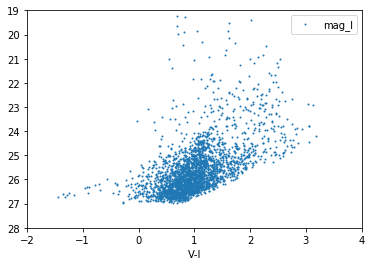

In [86]:
#V-I
mpl.rcParams['agg.path.chunksize'] = 10000
real_cut.plot(x='V-I',y='mag_I', marker='o', linestyle='None', markersize='1')
axes = plt.gca()
axes.set_xlim([-2,4])
axes.set_ylim([28,19])
plt.show()



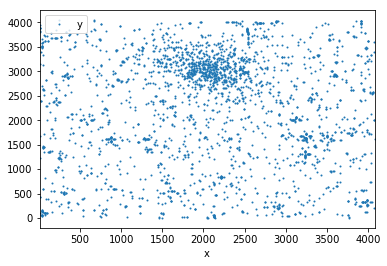

In [87]:
real_cut.plot(x='x',y='y', marker='o', linestyle='None', markersize='1.0')
xmin=min(real_cut['x'])
xmax=max(real_cut['x'])
ymin=min(real_cut['y'])
ymax=max(real_cut['y'])
plt.xlim(xmin,xmax)
plt.show()


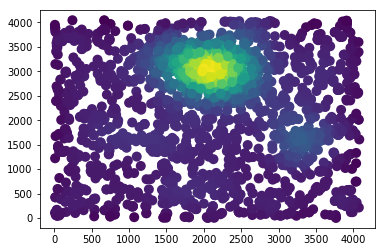

In [88]:
#density plot
x = real_cut['x']
y = real_cut['y']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')
plt.show()
#kernel.covariance_factor()

